<h1><center>Automatic Ticket Classification</center></h1>

### Authors: <br>
- Aditya Repekar
- Jayit Ghosh

### Problem Statement 
You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 

With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('/content/drive/MyDrive/Colab Notebooks/Automatic Ticket classification/complaints-2021-05-14_08_16 (1).json') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

df.shape

(78313, 22)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
pd.set_option('display.max_columns', 50)

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names
col_list = list(df.columns)
col_list

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
#Removing "_" from column names
df.columns=[re.sub('^_','',col) for col in df.columns]

#Removing "source." from column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [8]:
#Assign nan in place of blanks in the complaints column

round(df.isna().sum()*100/df.shape[0],2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened       0.00
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [9]:
# Remove all rows where complaints column is nan
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [10]:
# Inspect the number of missing values percentage
round(df.isna().sum()*100/df.shape[0],2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened      73.09
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [11]:
#Dropping NaN rows from "complaint_what_happened"
df.dropna(subset=['complaint_what_happened'], inplace=True)

#New shape of df
df.shape

(21072, 22)

In [12]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.


def clean_texts(text):
    #Make the text lowercase
    text=text.lower()
    
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    
    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text


In [14]:
#Cleaning df['complaint_what_happened']
df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: clean_texts(x))

In [15]:
#Write your function to Lemmatize the texts

def lemma_texts(text):     
        
    # Initialize empty list to store lemmas
    lemma_list = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [16]:
# Add a column for lemmatized complaints to the dataframe
df["lemmatized_complaint"] =  df.apply(lambda x: lemma_texts(x['complaint_what_happened']), axis=1)

# View the dataframe
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card be report on xx / xx/. however , fr..."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx / xx/ , while try to book a xxxx xxxx ..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for { $ . } I deposi...


In [17]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_what_happened','lemmatized_complaint']]

In [18]:
df_clean

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my..."
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...


In [19]:
from textblob import TextBlob
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

# function to extract the POS tags 

def pos_tag(text):
  # write your code here
  # Creating a textblob object
    text_blob = TextBlob(text)
    
    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])



df_clean["complaint_POS_removed"] = df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
<ipython-input-19-80389cb302a5>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday chas visa credit card provider claim...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [21]:
#lenght of character in 'complaint_POS_removed'
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
char_len[:10]

[159, 101, 67, 414, 155, 7, 650, 582, 1172, 51]

Text(0, 0.5, 'No. of Complaints')

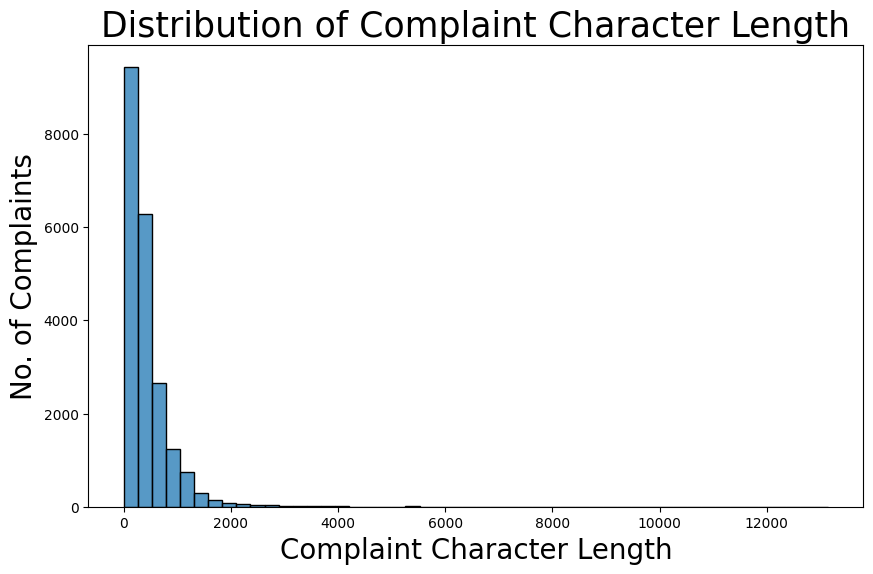

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

#### Find the top 40 words by frequency among all the articles after processing the text.

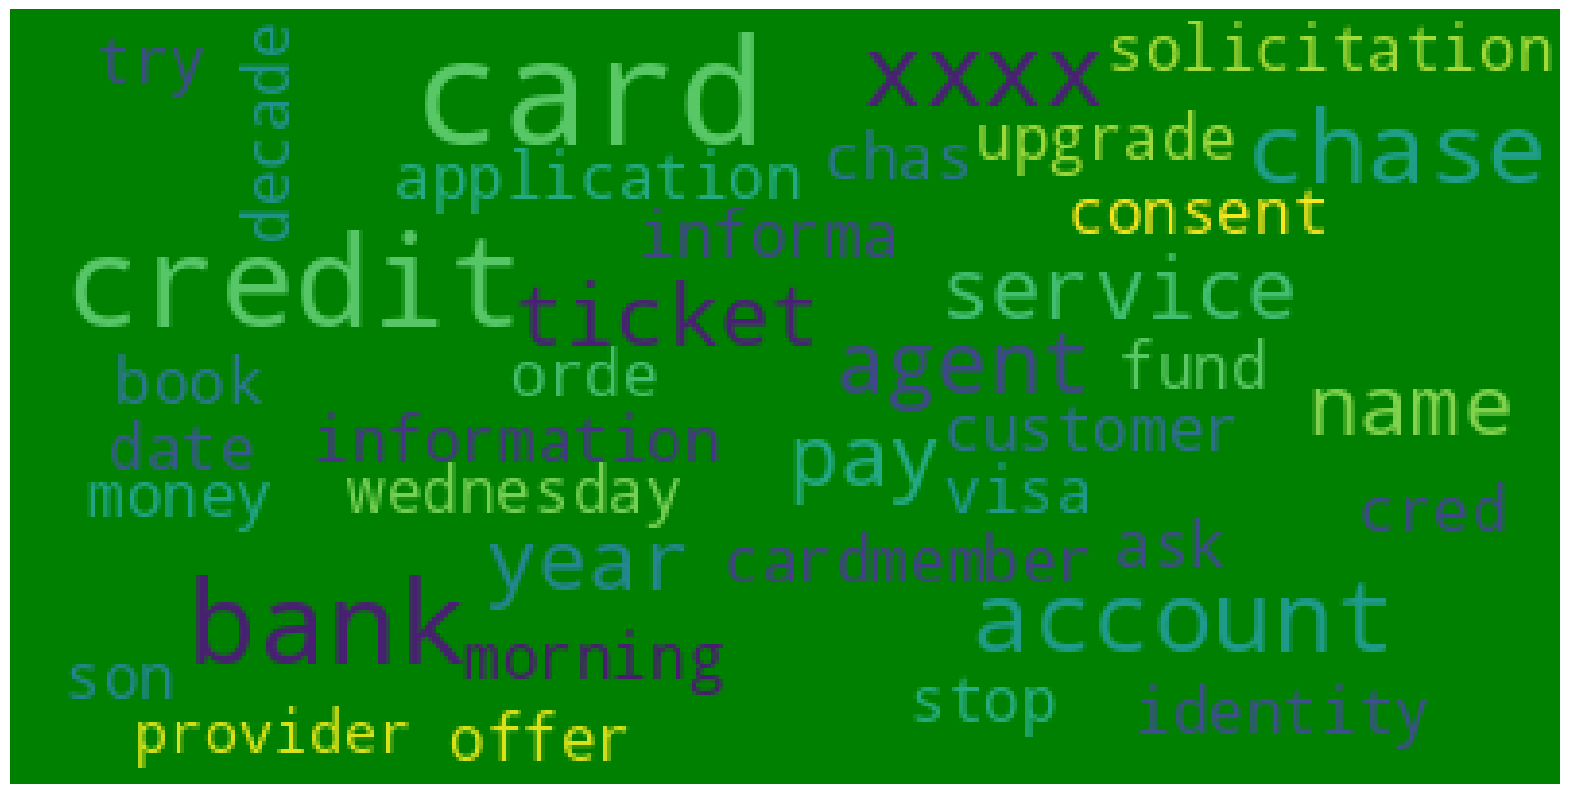

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='green',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [24]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

<ipython-input-24-2ee47e6ecbae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [25]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [26]:
#Print the top 10 words in the unigram frequency


top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,49221
1,account,47915
2,xxxx,43303
3,credit,34300
4,card,29633
5,bank,28503
6,payment,21338
7,time,16281
8,charge,15159
9,day,13073


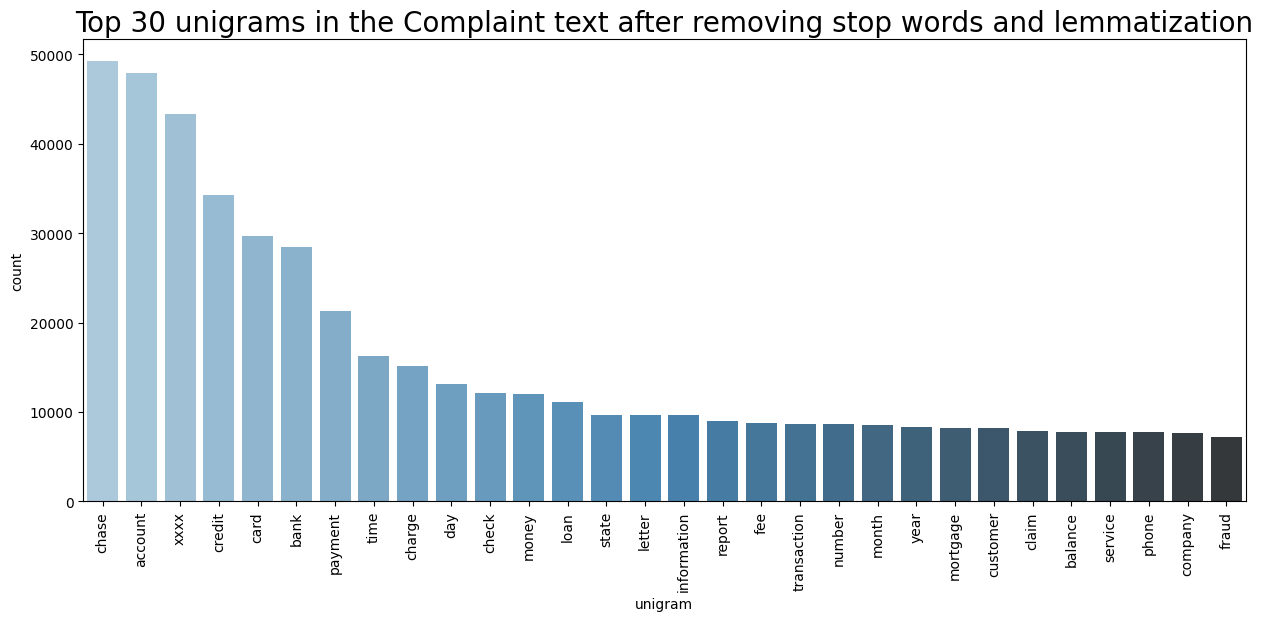

In [27]:
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [28]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [29]:
#Print the top 10 words in the bigram frequency

top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12878
1,xxxx xxxx,6249
2,credit report,3964
3,customer service,3082
4,chase credit,3064
5,chase bank,2938
6,account chase,2762
7,bank account,2751
8,chase account,2718
9,account account,2307


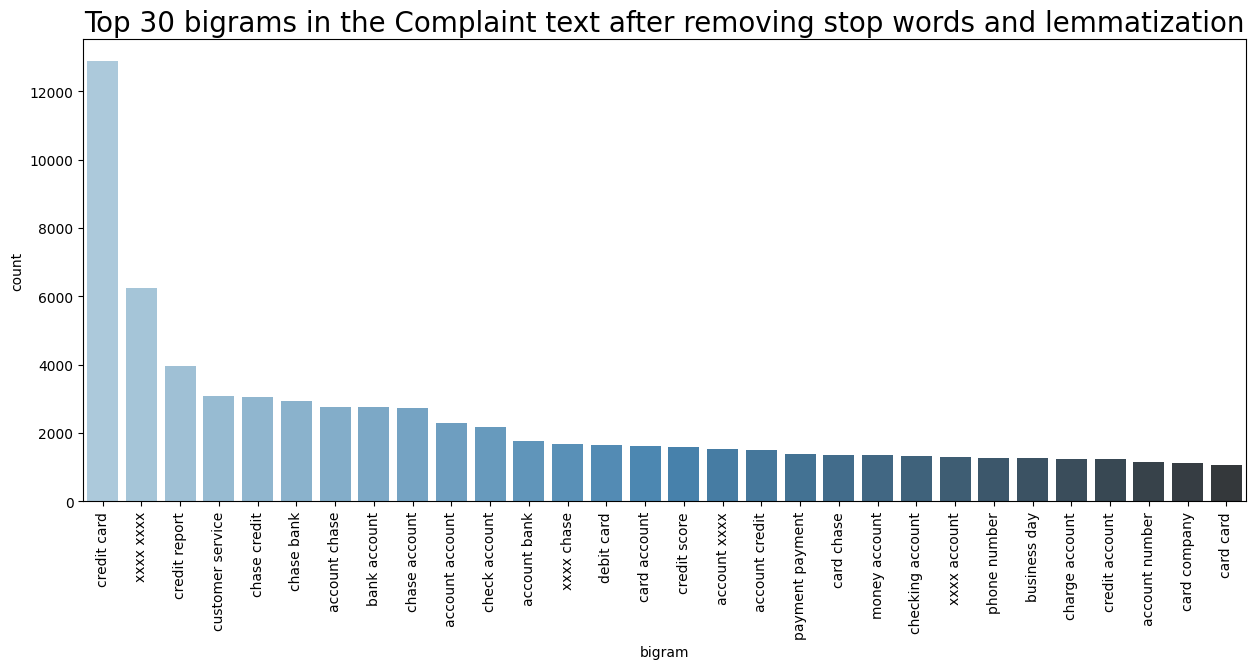

In [30]:
# Plot the top 30 bigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [31]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [32]:
#Print the top 10 words in the trigram frequency

top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2140
1,xxxx xxxx xxxx,1063
2,credit card account,1056
3,credit card company,995
4,credit card chase,672
5,credit card credit,507
6,inquiry credit report,483
7,charge credit card,430
8,account credit card,414
9,card credit card,382


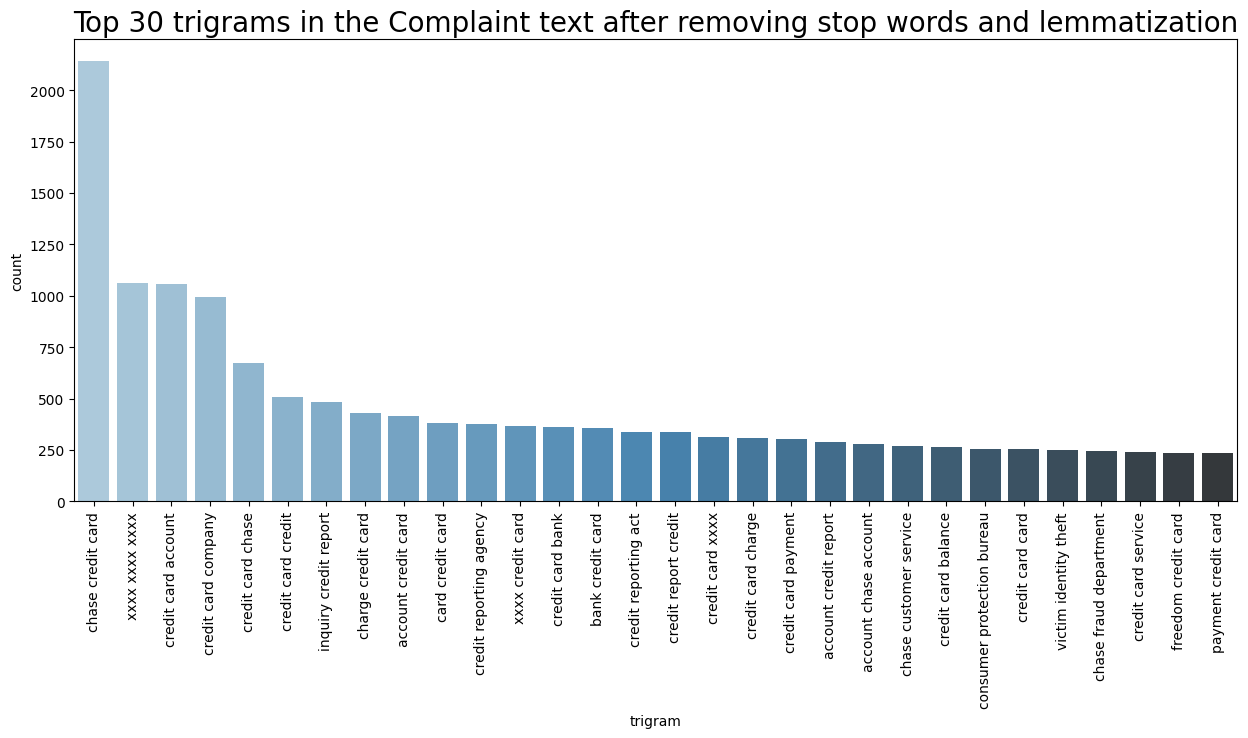

In [33]:
# Plot the top 30 trigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [34]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

<ipython-input-34-d4beb8194a2f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday chas visa credit card provider claim...,wednesday chas visa credit card provider claim...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [36]:
#Write your code here to initialise the TfidfVectorizer 

tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [37]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm=tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [38]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [39]:
df_clean.shape

(21072, 4)

In [40]:
#creating a copy of dataframe

df_cleanx =df_clean.copy()

In [41]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=5,random_state=40) #write your code here

In [42]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7120

In [43]:
# Print the top word of a sample component
topic_single = nmf_model.components_[0]
topic_single.argsort()
top_word_index = topic_single.argsort()[-10:]
for index in top_word_index:
    print(tfidf.get_feature_names_out()[index])

day
branch
xxxx
deposit
chase
fund
money
bank
check
account


In [44]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'transaction', 'number', 'business', 'day', 'branch', 'xxxx', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


TOP 15 WORDS FOR TOPIC #1
['year', 'letter', 'balance', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['foreclosure', 'house', 'bank', 'time', 'document', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'xxxx', 'mortgage', 'loan']


TOP 15 WORDS FOR TOPIC #3
['statement', 'time', 'refund', 'service', 'purchase', 'claim', 'fraud', 'merchant', 'fee', 'dispute', 'transaction', 'chase', 'xxxx', 'card', 'charge']


TOP 15 WORDS FOR TOPIC #4
['mortgage', 'year', 'chase', 'credit', 'account', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']




In [45]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([0, 3, 1, ..., 3, 4, 4])

In [46]:
#Assign the best topic to each of the cmplaints in Topic Column

df_cleanx['Topic'] = topic_result.argmax(axis=1) #write your code to assign topics to each rows.

In [47]:
df_cleanx.shape

(21072, 5)

In [48]:
df_cleanx.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [51]:
#Print the first 5 Complaint for each of the Topics
df_clean5=df_cleanx.groupby('Topic').head(5)
df_clean5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,mishandle account auto xxxx,mishandle account auto,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,j.p chase account debit card tuesday branch cu...,j.p chase account debit card tuesday branch cu...,0
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1
26,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...,time attempt inquiry creditor place inquiry re...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1


In [52]:
df_cleanx.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [53]:
df_cleanx.shape

(21072, 5)

In [54]:
#Create the dictionary of Topic names and Topics

df_cleanx.replace({'Topic':{0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}},inplace=True)

In [55]:
df_cleanx

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Theft/Dispute Reporting
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday chas visa credit card provider claim...,wednesday chas visa credit card provider claim...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,Mortgage/Loan


## Buidling a supervised model to predict any new complaints

In [56]:
df_cleanx.shape

(21072, 5)

In [57]:
#Create the dictionary again of Topic names and Topics

df_cleanx.replace({'Topic':{"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}},inplace=True)

In [58]:
df_cleanx

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday chas visa credit card provider claim...,wednesday chas visa credit card provider claim...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,4


In [59]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_cleanx[['complaint_what_happened','Topic']]

In [60]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,3
10,"chase card was reported on xx/xx/. however, fr...",1
11,"on xx/xx/, while trying to book a xxxx xxxx ...",1
14,my grand son give me check for {$.} i deposit ...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...",3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs. i've had ...,4


In [61]:
# View value counts of the five topics
training_data['Topic'].value_counts()

3    5136
0    5010
1    4809
2    3931
4    2186
Name: Topic, dtype: int64

In [62]:
training_data.shape

(21072, 2)

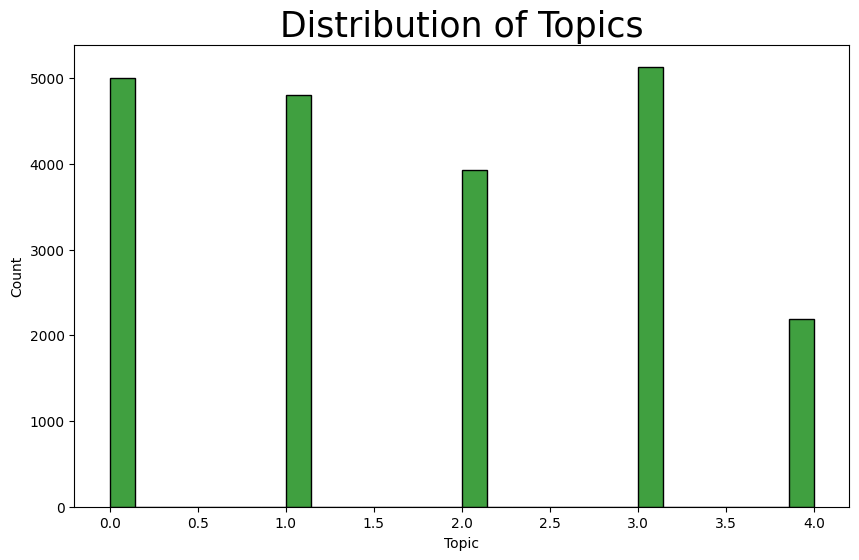

In [63]:
# Plotting a histogram of topics
plt.figure(figsize=[10,6])
sns.histplot(data=training_data, x='Topic',color='Green', )
plt.title("Distribution of Topics", fontsize=25)
plt.show()

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [64]:

#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])

In [65]:
# Saving Word Vector on disk for later usage
import pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [66]:
# Transform the word vector to tf-idf
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [67]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [68]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 27984)
y_train Shape: (15804,)
X_test Shape: (5268, 27984)
y_test Shape: (5268,)



**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [69]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Create a function to evaluate models
def model_eval(y_test, y_pred, model_name):
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return



In [74]:
# Importing libraries

from sklearn.metrics import confusion_matrix, f1_score, classification_report

# 1. Naive Bayes 

In [70]:
# Import required library
from sklearn.naive_bayes import MultinomialNB

In [71]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [72]:
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [73]:
# Creating model with best hyperparameter
model_name = 'NAIVE BAYES'
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [75]:
# Calculate F1 Score of model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb

0.77775205953062

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.77      0.83      0.80      1256
Credit card or prepaid card       0.80      0.76      0.78      1233
                     Others       0.83      0.84      0.83       942
    Theft/Dispute Reporting       0.78      0.77      0.77      1293
              Mortgage/Loan       0.66      0.64      0.65       544

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



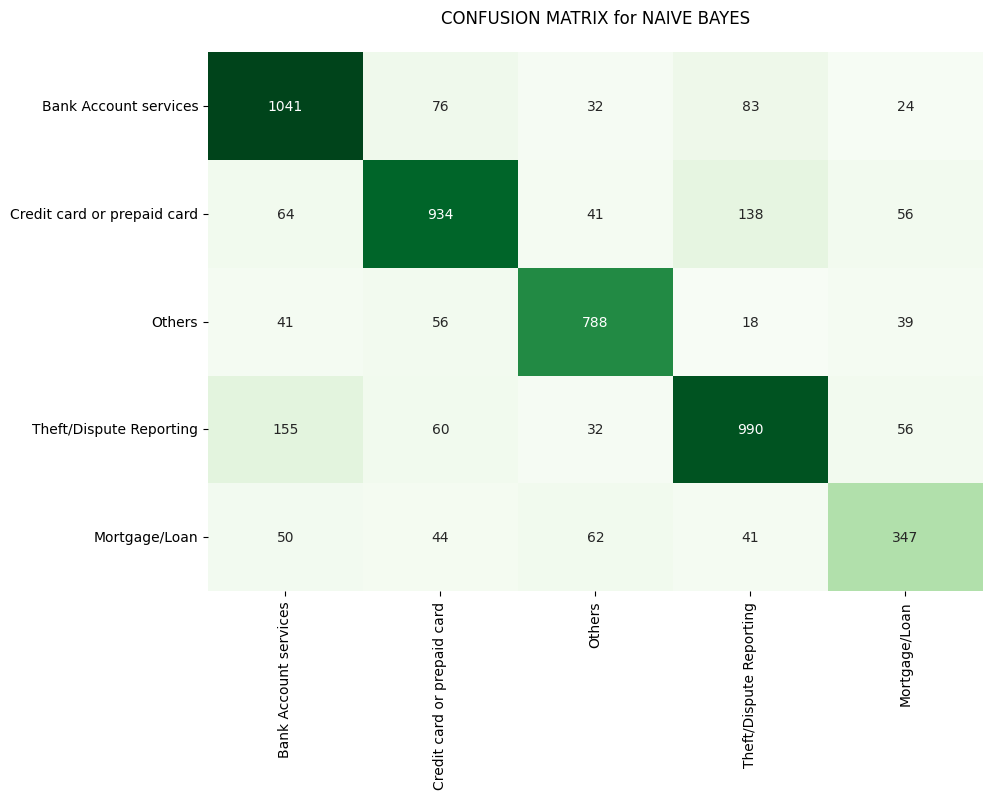

In [76]:
# Evaluate the Naive Bayes classifier
model_eval(y_test, y_pred_nb_tuned, model_name)

In [77]:
# Create a dataframe to store F1 Scores of all models we will build
f1_summary = pd.DataFrame([{'Model': 'Naive Bayes','F1 Score': round(f1_nb, 2)}])
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78


## 2. Logistic Regression

In [78]:
# Import required library
from sklearn.linear_model import LogisticRegression

In [79]:
# Run the Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression() 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [80]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [81]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [82]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9344390859264263

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.93      0.95      0.94      1256
Credit card or prepaid card       0.94      0.94      0.94      1233
                     Others       0.93      0.94      0.93       942
    Theft/Dispute Reporting       0.93      0.91      0.92      1293
              Mortgage/Loan       0.94      0.94      0.94       544

                   accuracy                           0.93      5268
                  macro avg       0.94      0.93      0.94      5268
               weighted avg       0.93      0.93      0.93      5268



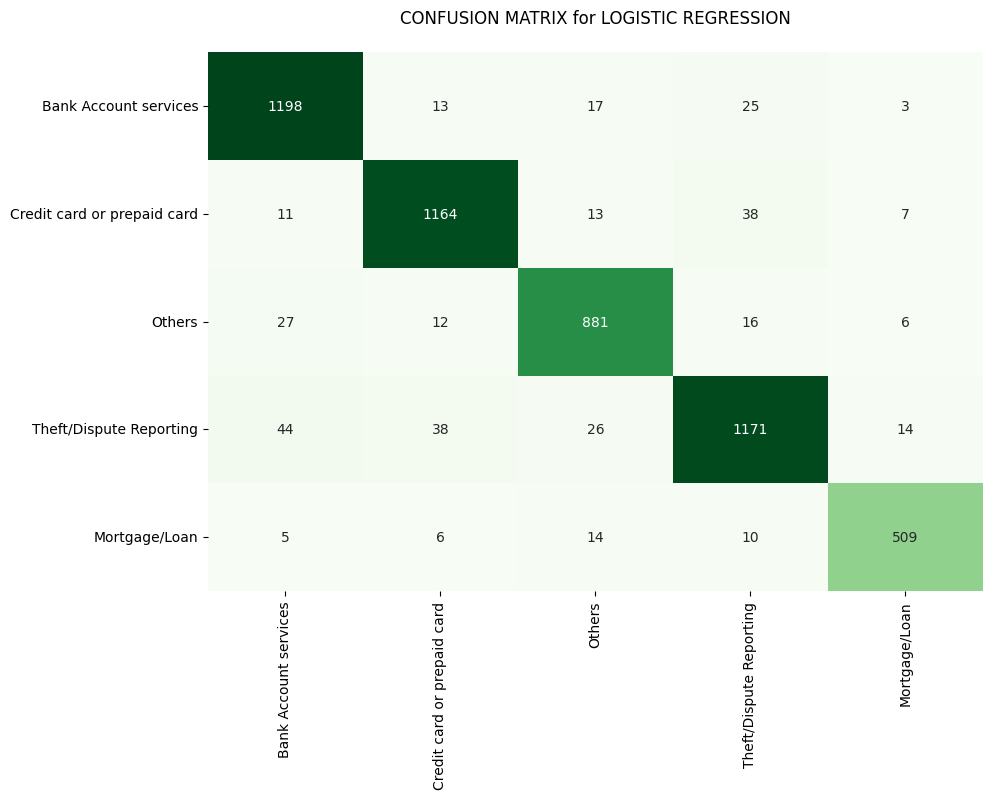

In [83]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_lr_tuned, model_name)

In [84]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Logistic Regression', round(f1_lr, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78
1,Logistic Regression,0.93


# 3. Decision Tree

In [85]:
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [86]:
# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [87]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 15}


In [88]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=15, 
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [89]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.7844344310558273

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.83      0.80      1256
Credit card or prepaid card       0.81      0.81      0.81      1233
                     Others       0.80      0.83      0.82       942
    Theft/Dispute Reporting       0.75      0.71      0.73      1293
              Mortgage/Loan       0.79      0.74      0.76       544

                   accuracy                           0.79      5268
                  macro avg       0.79      0.78      0.78      5268
               weighted avg       0.78      0.79      0.78      5268



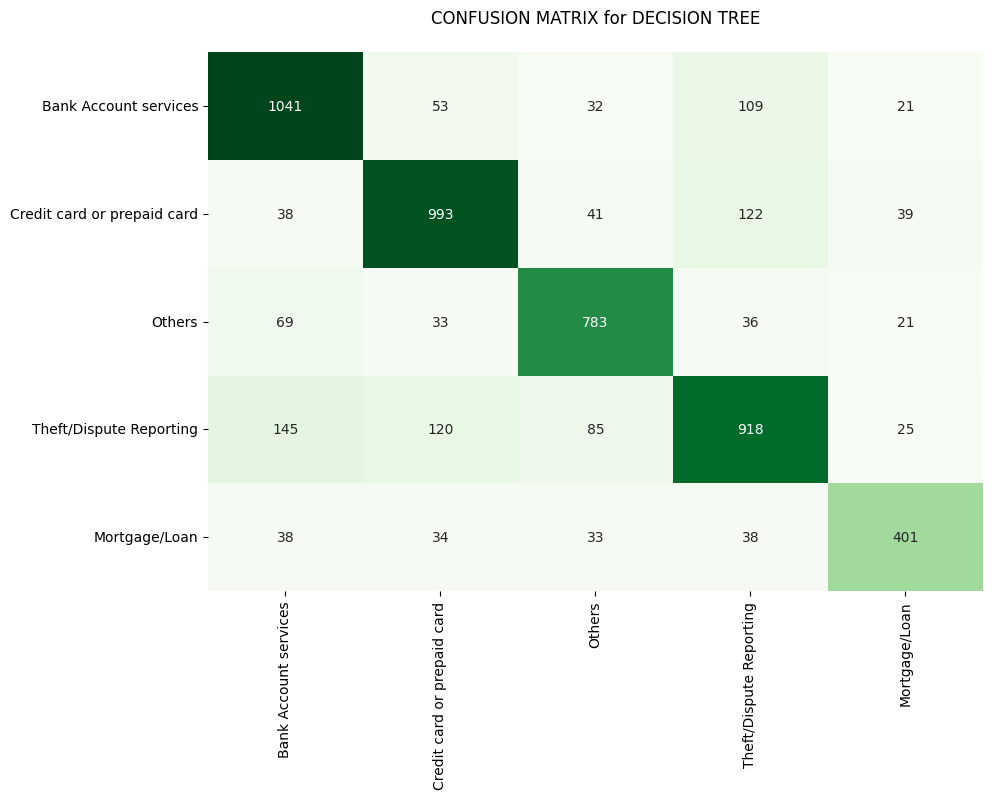

In [90]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, model_name)

In [91]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78
1,Logistic Regression,0.93
2,Decision Tree,0.78


# 4. Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [93]:
# Run the Logistic Regression model with default parameters
model_name = 'RANDOM FOREST'
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)

In [94]:
# Calculate F1 Score of tuned model using weighted average method
f1_rfc = f1_score(y_test, y_pred_rfc, average="weighted")
f1_rfc

0.70142412676327

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.76      0.87      0.81      1256
Credit card or prepaid card       0.67      0.82      0.74      1233
                     Others       0.85      0.74      0.79       942
    Theft/Dispute Reporting       0.71      0.82      0.76      1293
              Mortgage/Loan       1.00      0.04      0.08       544

                   accuracy                           0.73      5268
                  macro avg       0.80      0.66      0.64      5268
               weighted avg       0.77      0.73      0.70      5268



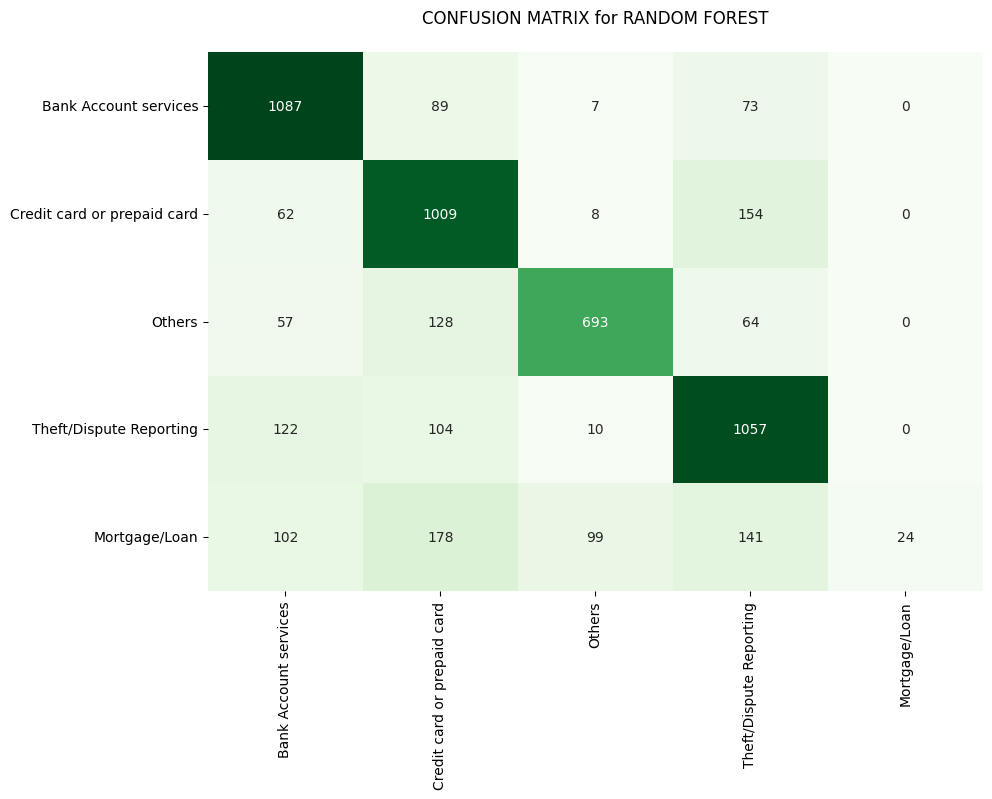

In [95]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_rfc, model_name)

In [96]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Random Forest', round(f1_rfc, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78
1,Logistic Regression,0.93
2,Decision Tree,0.78
3,Random Forest,0.70


In [97]:
# Save Logistic Regression model as pickle file in device
pickle.dump(lr_tuned, open("logreg_model.pkl", "wb"))

# Model Inference

In [98]:
# Function to predict a topic for custom text

def topic_predicter(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [99]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Patna?"]})
df_custom

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,unwanted service activated and money deducted ...
4,How can I know my CIBIL score?
5,Where are the bank branches in the city of Patna?


In [100]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predicter([x]))
df_custom

,complaints,predicted topic
0,I can not get from chase who services my mortg...,Others
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,unwanted service activated and money deducted ...,Bank Account services
4,How can I know my CIBIL score?,Credit card or prepaid card
5,Where are the bank branches in the city of Patna?,Bank Account services


# Conclusion

Based on our analysis and as per our Model, below are observation:

Logistic Regression model is predicting well on custom data with F1 score : 0.93